<a href="https://colab.research.google.com/github/prototype99/datasci-webinar/blob/main/pods_2223_w9_lec_resampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PoDS, 2022-23, Week 9, Resampling and Statistical Testing #1

## Preamble (Packages)

In [ ]:
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (8,6)}, style='ticks', context='talk', font_scale=0.8)

In [ ]:
# For some reason, Google Colab seems to be pulling out an older version
# of `matplotlib` that does not have an implementation of `axline`
# If I need it, I'll force an upgrade 
import matplotlib
matplotlib.__version__

'3.2.2'

## Reproducibility

In [ ]:
"""This sets up a random data generator for reproducibility. All functionality 
that involves some random data generation such as sampling from a normal 
distribution or suffling a data distribution, are accessible via `rng`"""
rng = np.random.default_rng(seed=42)

## Intro

* We will see **resampling** for quantifying (un)certainty about findings.

* The central idea here is on **quantifying (un)certainty** about an **estimate** or an **effect** seen in a data sample. The mindset is:

    - **Repeat experiment/measurement** a number of times using **different data samples** to obtain a sampling distribution of **estimates** of the desired properties (**estimands**) of a data distribution.

    - Estimands can be **mean**, mean **difference in groups**, **correlation**, **model accuracy**, among others.

    - From the **sampling distribution**, one can derive metrics such as **confidence interval** (i.e., range of values this estimate can take) and **significance level** (i.e., confidence that this not a fluke).

* Examples: 
    - Measurement is systolic blood pressure; data sample is a group of 100 patients of a hospital in Manchester. Mean is 118. How confident can I be about this value? If it was feasible/possible to measure it on 1000s to different samples, what range of values would I  normally see? What is the **confidence interval**?

    - **Difference in mean** systolic blood pressure between diabetic and non-diabetic patients is 12. Is this **significant**? If I were to **assume** that there was **no difference between the groups**, that the patients came from the same distribution, how often would I see a **difference as extreme**? (what is its **p-value**, if you'd like)

* Normally, not feasible to obtain 1000s of samples in the wild; no access to the data generation procedure; use then the **existing sample for generating other data samples**.

Why resampling?

* You would have done statistical testing before... Specially for non-statisticians, offers a more natural framework. Basically, you just neeed to code, simulate, measure, repeat. One does not need to make assumptions about the distribution of the data (e.g., that it is normally-distributed).

* Important for **claims** one would like to make (say, a group difference or a feature correlation) in typical data science projects.

* Also, useful **building block** under-the-hood; a key component of many techniques (e.g., ensemble models in machine learning). But this is for another lecture.



## A First Look at Bootstrapping/Sampling with Replacement

* Back to the main motivation for resampling: we would like to run an experiment over multiple samples, but we don't/might not have access to the data generating procedure. In that case, use the sample we have as the source, and bootstap-sample from it. 

* First, a quickly illustration of the concept, which involves sampling with replacement from a data ditribution to generate a single new sample.

* I am using an iterator to show each element sampled, up to completing one bootstrapped sample of systolic pressure measurements.

In [ ]:
"""This is our sample of systolic blood pressure measurements from 30 adults"""
sysp = np.array([ 
    89, 109, 130, 127, 116, 101, 130, 128, 105,  92,  99,  97, 124,
   123, 111, 116, 110, 110, 123, 125,  94, 113, 116, 112, 117,  93,
   106,  93, 107, 118
])

In [ ]:
"""The new sample is generated from the existing distribution `sysp` with 
sampling with replacement via numpy's `.choice()` (arguments are data to be 
sampled, and how many values to be sampled). 

Think of a bingo game; bag with tokens; caller draws a token at a time; 
places token back in bag.
"""

new_sample = rng.choice(sysp, len(sysp))
print(f"original sample is {np.sort(sysp)}")
print(f"new sample is {np.sort(new_sample)}")

original sample is [ 89  92  93  93  94  97  99 101 105 106 107 109 110 110 111 112 113 116
 116 116 117 118 123 123 124 125 127 128 130 130]
new sample is [ 93  93  93  94  97 101 110 112 112 112 113 116 116 116 116 116 117 118
 123 123 123 124 124 125 125 127 130 130 130 130]


In [ ]:
"""What are the means of the original data sample and its bootstrap sample?"""
# new sample is a list; I'll convert it to numpy array first
sysp.mean(), new_sample.mean()

(111.13333333333334, 115.3)

## Confidence Interval with Bootstrapping: Estimating the Mean of a Distribution

* I will demonstrate here the principle and usefulness of bootstrap sampling with the example of obtaining a confidence interval for the mean of a distribution.

### Building a Sampling Distribution of Means

* Let us start with 100 bootstrap samples of the original data and, then, observe the distribution of means (that is, the distribution of the mean value of each sample obtained via resampling from the original data).

In [ ]:
"""creates a empty two-dimensional array for the bootstrap samples (only 100
for this first simulation). The array has a (n,m) shape, where `n` is the number
of samples and `m` is the size of the (original) data sample (each row is a 
sample, in other words)."""
original_data = sysp
num_samples = 10000
bootstrap_samples = np.empty((num_samples, len(original_data)))
print(bootstrap_samples.shape)

(10000, 30)


In [ ]:
"""Builds the array with 100 samples. `i` is used for indexing the rows of the
array (from 0 to 99). `.choice()` is the resampler here; it takes the original
data as the argument (a numpy vector of `m` elements, which is our blood 
pressure measurements) and produces a data sample of the same size via
sampling with replacement."""
for i in range(0, num_samples):
    bootstrap_samples[i] = rng.choice(original_data, len(original_data))

In [ ]:
"""Just to make that this makes sense and is working, this is the first sample"""
bootstrap_samples[3]

array([123., 118., 111., 123., 123., 106., 117.,  93., 116., 112.,  99.,
       123., 116., 130., 113.,  89., 110., 111., 111., 111., 111., 124.,
       123., 110., 116., 110., 125.,  93., 118., 127.])

In [ ]:
"""and this is the mean of the first sample"""
bootstrap_samples[0].mean()

114.9

In [ ]:
"""the vectorised `.mean()` operation works across rows (`axis=1`), returning
a vector with 100 means (one for each sample)"""
bootstrap_means = bootstrap_samples.mean(axis=1)
# just a quick look to see if it makes sense
bootstrap_means

array([108.6       , 115.16666667, 106.        , ..., 110.33333333,
       112.5       , 113.5       ])

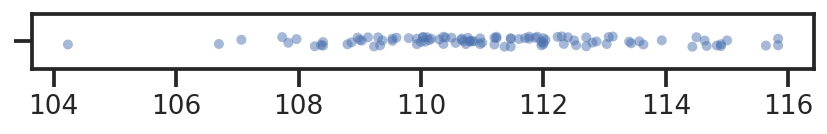

In [ ]:
"""We could have a look at the distribution of means along a number line
via a seaborn stripplot. I have added some transparency and jitter for easier
visualisation. Each dot is the mean of a bootstrap sample."""
fig, ax = plt.subplots(figsize=(7,0.5))
sns.stripplot(x=bootstrap_means, jitter=0.1, alpha=0.5, ax=ax);

### The Sampling Distribution of Means as a Histogram, and Percentiles

* We have now a **sampling distribution** of **means** of diastolic blood pressure samples. I am only using only 100 for ease of demonstration. For observing the centrality and dispersion of that distribution, a histogram comes handy. I am adding a *rug* so that we can see where individual points lie.

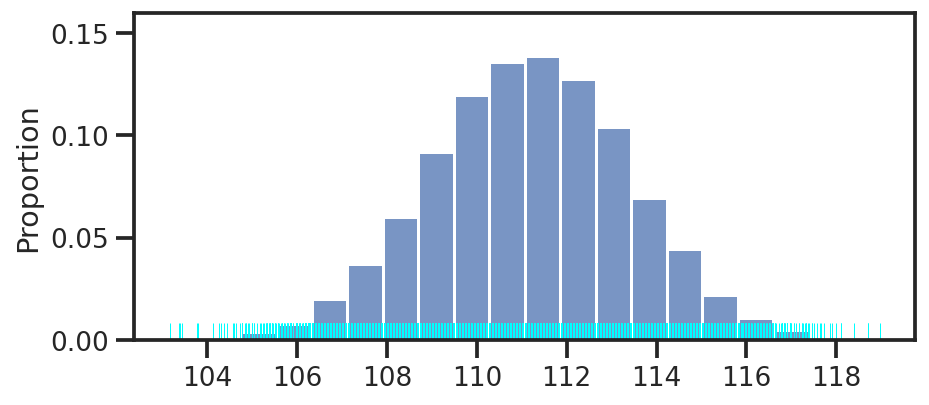

In [ ]:
fig, ax = plt.subplots(figsize=(7,3))
ax = sns.histplot(x=bootstrap_means, stat='proportion', bins=20)
sns.rugplot(x=bootstrap_means, ax=ax, color="aqua", height=0.05, linewidth=0.5);
# One can find matplotlib named colours at 
# https://matplotlib.org/stable/gallery/color/named_colors.html

* We get to the point of obtaining a confidence interval now, based on our sampling distribution of means from the bootstrap samples. The mean of the original sample of systolic blood pressures is:

In [ ]:
original_data.mean()

111.13333333333334

To obtain a **95% confidence interval**, we just need to look at the middle 95% of the sampling distribution and pick up the **percentiles** that define that range (95% is the most common, but you could well decide on 90%, 99%, and so on).

The histogram below has lines representing the mean and the median, as well as the 2.5 and 97.5 quantiles, which demarcate the middle 95% interval for mean values.

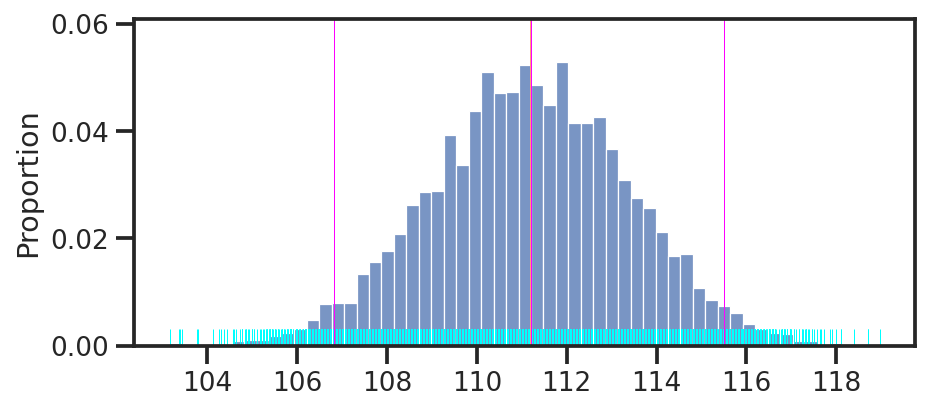

In [ ]:
fig, ax = plt.subplots(figsize=(7,3))
ax = sns.histplot(x=bootstrap_means, stat="proportion")
sns.rugplot(x=bootstrap_means, ax=ax, height=0.05, color="aqua", linewidth=0.5);

ax.axvline(bootstrap_means.mean(), color="lightsalmon", linewidth=0.5)
ax.axvline(np.percentile(bootstrap_means, 2.5), color="fuchsia", linewidth=0.5)
ax.axvline(np.percentile(bootstrap_means, 50), color="fuchsia", linewidth=0.5)
ax.axvline(np.percentile(bootstrap_means, 97.5), color="fuchsia", linewidth=0.5);

In [ ]:
"""So, these are the mean and the confidence interval (at 95% level) of 
systolic blood pressures"""
print(original_data.mean())
print(np.percentile(bootstrap_means, 2.5))
print(np.percentile(bootstrap_means, 97.5))

111.13333333333334
106.83333333333333
115.5


In [ ]:
"""or simply"""
print(np.mean(original_data), np.percentile(bootstrap_means, [2.5,97.5]))

111.13333333333334 [107.38333333 115.3325    ]
